In [1]:
import numpy as np
import scipy.optimize as sci
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/Users/gilbertbahatij/mbrl-traffic/')
# from mbrl_traffic.models.lwr import LWRModel
# from mbrl_traffic.models.arz import ARZModel
import numpy as np

# Fundamental Diagram


In [2]:
# read data 75 folder
dir = "/Users/gilbertbahatij/sumo-idm/75/macro/"
data = pd.DataFrame()
file_list = os.listdir(dir)
for file in file_list:
    if ".csv" in file:
        T = pd.read_csv(dir + file)
        data = pd.concat([data, T])

In [3]:
# get speeds and densities
speeds = data.loc[:, data.columns.str.contains("speed")]
densities = data.loc[:, data.columns.str.contains("density")]

In [4]:
#get flows
col = speeds.columns.str.replace("speed", "flow")
flow = (speeds * densities.values)
flow.columns = col

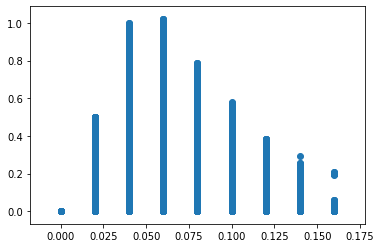

In [16]:
#plot FD
plt.scatter(densities, flow)
plt.show()

# Nedler - Mead Method

In [6]:
"""Calibrate LWR with Data"""
from scipy.optimize import minimize
from flow.core.macroscopic import LWR
from flow.core.macroscopic.lwr import PARAMS as LWR_PARAMS
from flow.core.macroscopic.utils import run
from flow.core.macroscopic.Calibration.aggregate_micro_to_macro import agg_func
params = LWR_PARAMS.copy()


In [7]:
# set static parameters
params["length"] = 30
params['rho_max_max'] = 1
params["dx"] = 1
params["dt"] = 0.5
params['boundary_conditions'] = "loop"

# set inital conditions and solutions
params['initial_conditions'] = np.array(densities.iloc[1,:])
solution = np.array(densities.iloc[50,:])

In [8]:
# LWR [rho_max, lam] 
# ARZ = [rho_max, v_max, lam, tau]

def objective(x):
    global loss_array
    
    # load params
    params['rho_max'] = x[0]
    params["lam"] = x[1]
    
    #run one time step
    env = LWR(params)
    obs = env.reset()
    obs, _, _, _ = env.step(rl_actions = params['v_max'])
    
    lwr_density_pred = obs[:int(obs.shape[0]/2)]
    lwr_speeds_pred = obs[int(obs.shape[0]/2):]

    #loss function; root mean square error
    loss = np.sqrt(np.mean((solution - lwr_density_pred)**2))
    
    # logging/Plotting
    loss_array = np.append(loss_array,loss)
    return loss


Optimization terminated successfully.
         Current function value: 0.016246
         Iterations: 106
         Function evaluations: 250
Optimal Parameter = [0.13691372 0.5571348 ]


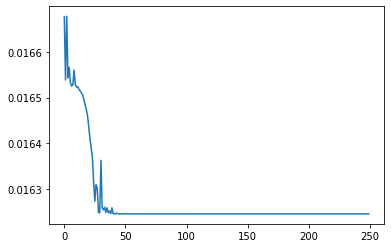

In [12]:
# for logging purposes/Plotting
global loss_array
loss_array = np.array([])

#set inital values and bounds
x0 = [0.1, 0.1]
bnds = [(0.0,4.0), (0.0,1.0)]

# solve single run
sol = minimize(objective,x0, 
               method="Nelder-Mead", 
               bounds=bnds, 
               tol=1e-1000, 
               callback=None,
               options = {"disp" : True})

print("Optimal Parameter = {}".format(sol.x) )
plt.plot(loss_array)
plt.show()

# Cross Entopy

In [74]:
#https://github.com/jerrylin1121/cross_entropy_method